# GBDT and RF on Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD 
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score


from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
#from prettytable import PrettyTable
import warnings
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
F:\Users\Admin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Reading back the preprocessed data saved in final.sqlite

In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
df_data=df.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [4]:
my_final = df_data[:5000]
print(my_final.shape)

(5000, 12)


In [5]:
X = my_final['CleanedText']
y = my_final['Score']

In [6]:
score = {'positive': 1,'negative': 0}
y = [score[item] for item in y] 

In [7]:
# split the data set into crossvalidation train and test
X_train, X_test, y_train, y_test =cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, len(y_train), X_test.shape, len(y_test))

(3500,) 3500 (1500,) 1500


#### Hyperparameter tuning of RandomForest Classifier using GridSearchCV

In [56]:
from sklearn.ensemble import RandomForestClassifier
base_learners = [30,40,50,60,70,80,90,100,120,150]
param = {'n_estimators': base_learners}
#f1_scorer = make_scorer(f1_score, pos_label="positive")

estimator=RandomForestClassifier(class_weight='balanced_subsample',max_features='sqrt',min_samples_leaf=20)

model = GridSearchCV(estimator,param, scoring = 'f1', cv=3,pre_dispatch=2)

#### Hyperparameter tuning of XGB Classifier using GridSearchCV

In [8]:
from xgboost import XGBClassifier
Depths = [3,4,5,6,7,8,9,10,11]
base_learners = [50,100,120,150,180,200,300,400,500,600]
Learning_rate = [0.05,0.1,0.2,0.3]
param_grid = {'n_estimators': base_learners,'max_depth': Depths,'learning_rate':Learning_rate}
#f1_scorer = make_scorer(f1_score, pos_label="positive")
estimator=XGBClassifier(min_samples_leaf = 20,class_weight='balanced')
model_gbt = GridSearchCV(estimator,param_grid, scoring ='roc_auc', cv=3,pre_dispatch=2)

# Bag of Words (BoW)

In [9]:
count_vec = CountVectorizer(min_df=100)
X_trainbow = count_vec.fit_transform(X_train)
# Test Vectorizor
X_testbow = count_vec.transform(X_test)
print(X_trainbow.shape)
print(X_testbow.shape)

(3500, 207)
(1500, 207)


#### RF with GridSearchCV

In [10]:
model.fit(X_trainbow,y_train) 
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


#### Validation Curve

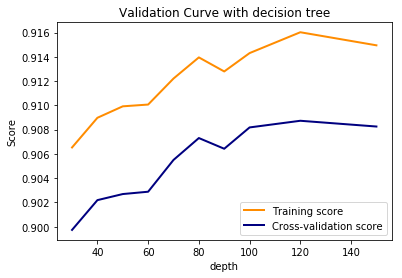

In [14]:
 
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve( estimator, X_trainbow, y_train, param_name="n_estimators", 
                                             param_range=base_learners,cv=3, scoring=f1_scorer, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel("depth")
plt.ylabel("Score")
plt.plot(base_learners, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.plot(base_learners, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.legend(loc="best")
plt.show()

#### Accuracy Report

In [27]:
clf =RandomForestClassifier(n_estimators=150)

# fitting the model
clf.fit(X_trainbow,y_train)

# predict the response
pred_bow=clf.predict(X_testbow)
pred_train=clf.predict(X_trainbow)
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
acc_train_bow = clf.score(X_trainbow,y_train)*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))
print("-------------------------------------------------")
print(classification_report(y_test, pred_bow))


The accuracy of the classifier is 87.613333%
accuracy on train data is 100.0%
error on train data is 0.0%
error on test data is 12.38666666666667%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.34      0.50      1333
          1       0.87      0.99      0.93      6167

avg / total       0.88      0.88      0.85      7500



#### Confusion Matrix

Text(0.5, 24.0, 'Predicted label')

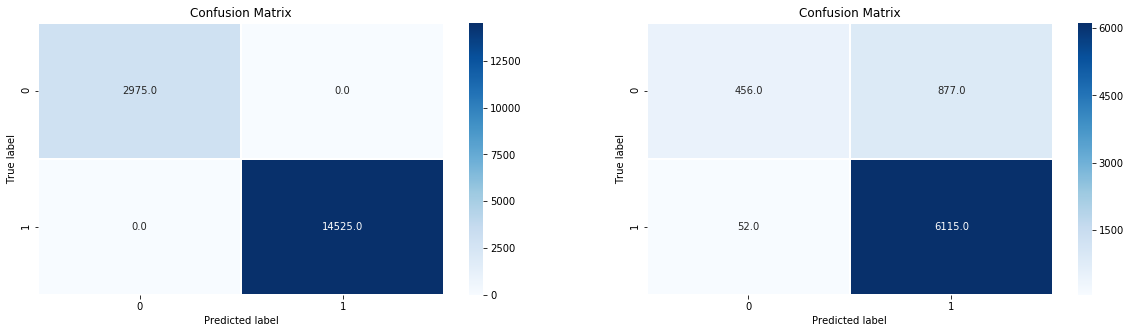

In [28]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_bow)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

In [29]:
W = clf.feature_importances_
type(W)

numpy.ndarray

In [30]:
W

array([1.29098255e-05, 5.40186290e-04, 4.66360932e-04, ...,
       1.87360007e-05, 6.20932125e-05, 3.35505501e-06])

In [41]:
negative_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[0:50]
positive_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[1950:2000]

In [42]:
neg={}
pos={}
for index in negative_log:
    for i in count_vec.vocabulary_:
        if count_vec.vocabulary_[i] == index:
            neg[i]=clf.feature_importances_[index]
            
for index in positive_log:
    for i in count_vec.vocabulary_:
        if count_vec.vocabulary_[i] == index:
            pos[i]=clf.feature_importances_[index]

In [45]:
neg

{'assist': 2.2050383902475008e-08,
 'attack': 3.416138747635962e-06,
 'attend': 7.061249407905141e-07,
 'blind': 2.540210716284624e-06,
 'bolder': 7.139844380717679e-08,
 'boneless': 3.33640905151465e-06,
 'boss': 4.766562710539464e-08,
 'chronic': 1.9949977821493156e-06,
 'confess': 2.169374976469035e-06,
 'cottag': 3.193156977287754e-06,
 'couscous': 1.5074213583096146e-06,
 'deeper': 1.338167988990742e-07,
 'divid': 2.0620482818118197e-06,
 'drag': 3.1739295097782408e-06,
 'economi': 2.022567309280712e-06,
 'expand': 2.9619471649938504e-06,
 'forest': 2.0925612950670143e-06,
 'ghee': 9.714473932683182e-07,
 'goat': 2.5679429948371573e-06,
 'haha': 2.7280705036855876e-06,
 'hostess': 2.64407842514783e-06,
 'invent': 0.0,
 'java': 2.975180816060742e-07,
 'jitter': 1.798233296796003e-06,
 'mainstream': 9.94457031095164e-07,
 'marmalad': 2.1501731758712593e-06,
 'mmmmm': 1.716640393383369e-06,
 'nephew': 3.1073389219037824e-06,
 'nurs': 2.8842360064873e-06,
 'pesto': 3.252104181561697e-

In [46]:
pos

{'accept': 0.00011089256353182241,
 'alot': 0.00011404517033394954,
 'altoid': 0.00010964718147664101,
 'appetit': 0.0001108144441613515,
 'attach': 0.00011279660414431745,
 'click': 0.00011043802511220546,
 'decor': 0.00011525689807716568,
 'dinner': 0.00010894052657710193,
 'dispens': 0.00011321210906818303,
 'effort': 0.0001153628670528468,
 'error': 0.00010953807805326294,
 'face': 0.00011334432862251049,
 'fade': 0.00011537279719623957,
 'fedex': 0.00011503759848497718,
 'foam': 0.0001142073994638641,
 'gallon': 0.00011050411125026228,
 'giant': 0.00011184541189424528,
 'greas': 0.00011264320013943997,
 'hell': 0.00011164114431566249,
 'herbal': 0.00011029556705072087,
 'household': 0.00011102997154827848,
 'instinct': 0.00010990029103941025,
 'jim': 0.00011075482277634996,
 'korean': 0.00010883469349906233,
 'layer': 0.00010895701929025739,
 'limit': 0.00011238872914084308,
 'mash': 0.00011240199806951162,
 'match': 0.00011507995282110113,
 'math': 0.00010927218252640199,
 'oatme

#### GBDT Using GridSearch CV

In [13]:
count_vec = CountVectorizer(min_df=10)
X_trainbow = count_vec.fit_transform(X_train)
# Test Vectorizor
X_testbow = count_vec.transform(X_test)
print(X_trainbow.shape)
print(X_testbow.shape)

(17500, 3644)
(7500, 3644)


In [10]:
model_gbt.fit(X_trainbow,y_train) 
print(model_gbt.best_estimator_)

KeyboardInterrupt: 

In [14]:
clf =XGBClassifier(n_estimators=600,learning_rate=0.1,max_depth=10)

# fitting the model
clf.fit(X_trainbow,y_train)

# predict the response
pred_bow=clf.predict(X_testbow)
pred_train=clf.predict(X_trainbow)
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
acc_train_bow = clf.score(X_trainbow,y_train)*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))
print("-------------------------------------------------")
print(classification_report(y_test, pred_bow))

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



The accuracy of the classifier is 90.493333%
accuracy on train data is 98.93142857142857%
error on train data is 1.0685714285714312%
error on test data is 9.50666666666666%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.84      0.57      0.68      1333
          1       0.91      0.98      0.94      6167

avg / total       0.90      0.90      0.90      7500



/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5, 24.0, 'Predicted label')

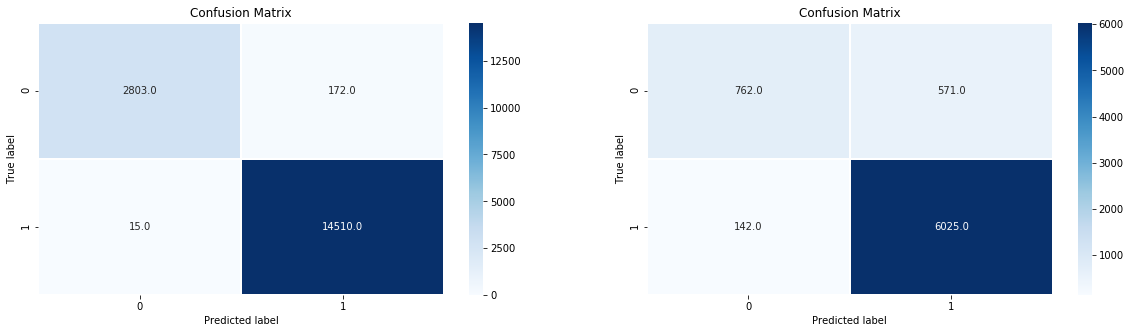

In [15]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_bow)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

In [24]:
W = clf.feature_importances_
type(W)


numpy.ndarray

In [25]:
W

array([0.        , 0.00021616, 0.00021616, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [21]:
bow_features = count_vec.get_feature_names()
type(bow_features)

list

In [16]:
negative_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[0:10]
positive_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[1990:2000]

In [19]:
neg={}
pos={}
for index in negative_log:
    for i in count_vec.vocabulary_:
        if count_vec.vocabulary_[i] == index:
            neg[i]=clf.feature_importances_[index]
            
for index in positive_log:
    for i in count_vec.vocabulary_:
        if count_vec.vocabulary_[i] == index:
            pos[i]=clf.feature_importances_[index]

In [20]:
neg

{'abil': 0.0,
 'opposit': 0.0,
 'opt': 0.0,
 'optim': 0.0,
 'option': 0.0,
 'oral': 0.0,
 'ordinari': 0.0,
 'oregano': 0.0,
 'oregon': 0.0,
 'oreo': 0.0}

In [26]:
pos

{'accord': 0.0,
 'account': 0.0,
 'accur': 0.0,
 'accustom': 0.0,
 'ach': 0.0,
 'achiev': 0.0,
 'acid': 0.0,
 'acquir': 0.0,
 'across': 0.0,
 'act': 0.0}

# TF-IDF

In [59]:
tfidf = TfidfVectorizer(min_df=10) #Using bi-grams
X_traintfidf = tfidf.fit_transform(X_train)
print("Train Data Size: ",X_traintfidf.shape)
X_testtfidf = tfidf.transform(X_test)
print("Test Data Size: ",X_testtfidf.shape)

Train Data Size:  (17500, 3644)
Test Data Size:  (7500, 3644)


#### RF with GridSearchCV

In [17]:
model.fit(X_traintfidf,y_train)
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


#### Validation Curve

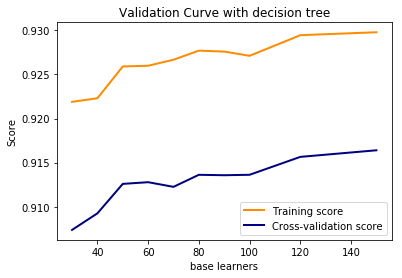

In [24]:
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve( estimator, X_traintfidf, y_train, param_name="n_estimators", 
                                             param_range=base_learners,cv=3, scoring=f1_scorer, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel("base learners")
plt.ylabel("Score")
plt.plot(base_learners, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.plot(base_learners, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.legend(loc="best")
plt.show()

#### Accuracy Report

In [62]:
clf =RandomForestClassifier(n_estimators=150)

# fitting the model
clf.fit(X_traintfidf, y_train)

# predict the response
pred_tfidf=clf.predict(X_testtfidf)
pred_train=clf.predict(X_traintfidf)
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
acc_train_tfidf = clf.score(X_traintfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_tfidf))


The accuracy of the classifier is 87.520000%
accuracy on train data is 100.0%
error on train data is 0.0%
error on test data is 12.480000000000004%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.33      0.48      1333
          1       0.87      0.99      0.93      6167

avg / total       0.88      0.88      0.85      7500



#### Confusion Matrix

Text(0.5, 24.0, 'Predicted label')

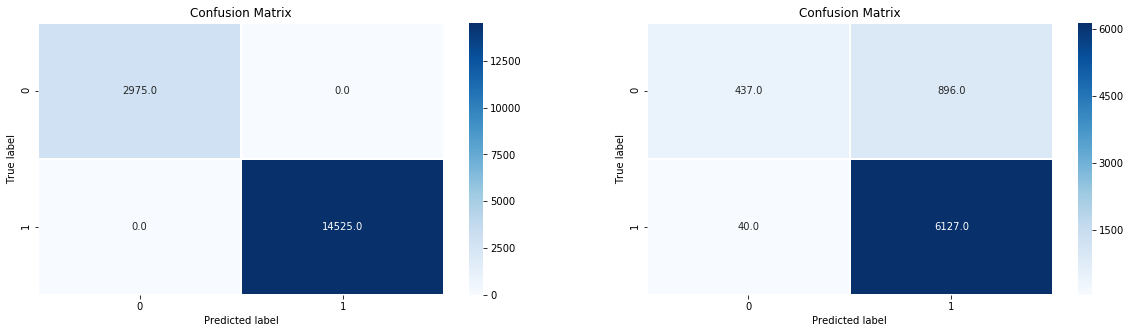

In [63]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_tfidf)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

#### GBDT Using GridSearch CV

In [13]:
model_gbt.fit(X_traintfidf,y_train)
print(model_gbt.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=4, min_child_weight=1,
       min_samples_leaf=20, missing=None, n_estimators=600, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [60]:
clf =XGBClassifier(max_depth=4,learning_rate=0.2,n_estimators=600)

# fitting the model
clf.fit(X_traintfidf, y_train)

# predict the response
pred_tfidf=clf.predict(X_testtfidf)
pred_train=clf.predict(X_traintfidf)
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_tfidf))
acc_train_tfidf = clf.score(X_traintfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_tfidf))

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



The accuracy of the classifier is 90.413333%
accuracy on train data is 98.04%
error on train data is 1.9599999999999937%
error on test data is 9.586666666666659%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.56      0.68      1333
          1       0.91      0.98      0.94      6167

avg / total       0.90      0.90      0.90      7500



/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5, 24.0, 'Predicted label')

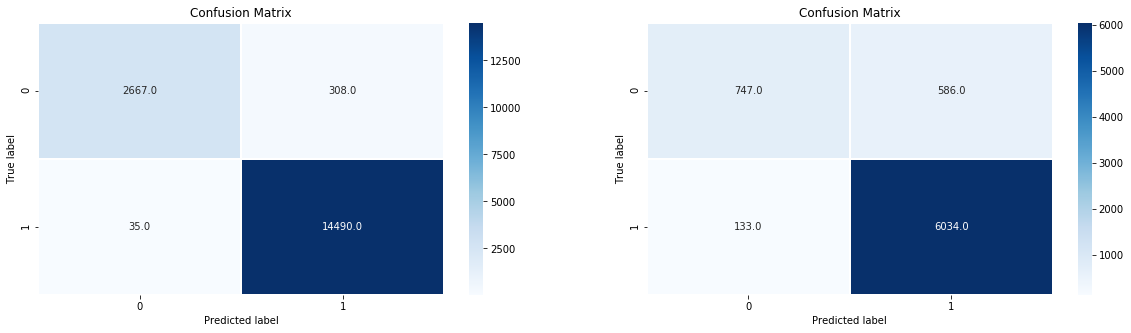

In [61]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_tfidf)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')


# Word TO Vec

In [47]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [48]:
# Train your own Word2Vec model using your own train corpus
import gensim
list_of_sent = []
for sent in X_train:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [49]:
# min_count = 5 considers only words that occured atleast 5 times

from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [50]:
# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   

# Avg W2V, TFIDF-W2V

In [51]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


 47%|████▋     | 8274/17500 [00:01<00:01, 5172.25it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 17500/17500 [00:03<00:00, 5116.98it/s]

17500
300


In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 7500/7500 [00:01<00:00, 4993.52it/s]

7500
300


In [53]:
X_trainw2v = np.array(sent_vectors)
X_testw2v=np.array(sent_vectors_test)
X_trainw2v=np.nan_to_num(X_trainw2v)
X_testw2v=np.nan_to_num(X_testw2v)

#### Decision Tree using GridSearch CV 

In [28]:
model.fit(X_trainw2v,y_train)
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


#### Validation Curve

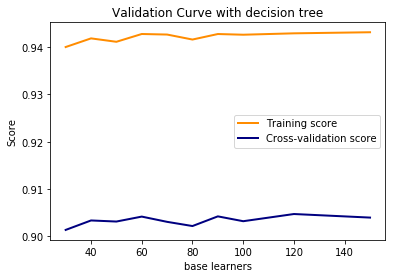

In [58]:
 
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve( estimator, X_trainw2v, y_train, param_name="n_estimators", 
                                             param_range=base_learners,cv=3, scoring='f1', n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel("base learners")
plt.ylabel("Score")
plt.plot(base_learners, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.plot(base_learners, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.legend(loc="best")
plt.show()

#### Accuracy Report

In [19]:
clf =RandomForestClassifier(n_estimators=150)

# fitting the model
clf.fit(X_trainw2v,y_train)

# predict the response
pred_w2v=clf.predict(X_testw2v)
pred_train=clf.predict(X_trainw2v)
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2v))
acc_train_w2v = clf.score(X_trainw2v,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2v))


The accuracy of the classifier is 86.133333%
accuracy on train data is 100.0%
error on train data is 0.0%
error on test data is 13.866666666666674%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.73      0.34      0.47      1333
          1       0.87      0.97      0.92      6167

avg / total       0.85      0.86      0.84      7500



Text(0.5, 24.0, 'Predicted label')

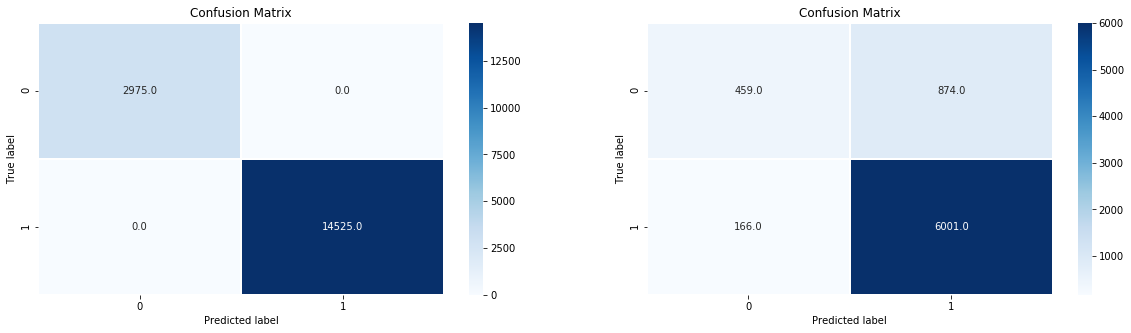

In [20]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_w2v)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

#### GBDT Using GridSearch CV

In [ ]:
model_gbt.fit(X_trainw2v,y_train)
print(model_gbt.best_estimator_)

## TF-IDF weighted Word2Vec

In [64]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [65]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf = TfidfVectorizer()
X_traintfidf = tfidf.fit_transform(X_train)
X_testtfidf = tfidf.transform(X_test)
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 17500/17500 [01:09<00:00, 250.68it/s]


In [66]:
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 7500/7500 [00:30<00:00, 245.70it/s]


In [67]:

X_trainw2vtfidf=np.array(tfidf_sent_vectors)
X_testw2vtfidf=np.array(tfidf_sent_vectors_test)

In [68]:
X_trainw2vtfidf.shape


(17500, 50)

In [69]:
X_trainw2vtfidf=np.nan_to_num(X_trainw2vtfidf)

#### RF using RandomSearch CV 

In [77]:
base_learners = [30,40,50,60,70,80,90,100,120,150]
param = {'n_estimators': base_learners}
#scorer = make_scorer(recall_score, pos_label="positive")
estimator=RandomForestClassifier(min_samples_leaf=20,class_weight='balanced_subsample')
model = RandomizedSearchCV(estimator,param, scoring = 'f1', cv=3)

In [78]:
model.fit(X_trainw2vtfidf,y_train)
print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


#### Validation Curve

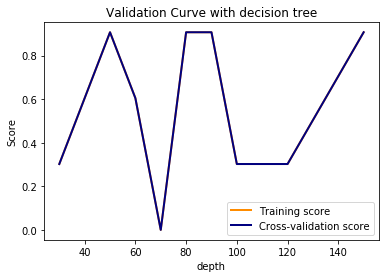

In [80]:
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve( estimator, X_trainw2vtfidf, y_train, param_name="n_estimators", 
                                             param_range=base_learners,cv=3, scoring='f1', n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with decision tree")
plt.xlabel("depth")
plt.ylabel("Score")
plt.plot(base_learners, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.plot(base_learners, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.legend(loc="best")
plt.show()

#### Accuracy Report

In [85]:
clf =RandomForestClassifier(n_estimators=100)

# fitting the model
clf.fit(X_trainw2vtfidf, y_train)

# predict the response
pred_w2vtfidf=clf.predict(X_testw2vtfidf)
pred_train=clf.predict(X_trainw2vtfidf)

acc_w2vtfidf = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_w2vtfidf))
acc_train_w2vtfidf = clf.score(X_trainw2vtfidf,y_train)*100
print("accuracy on train data is {}%".format(acc_train_w2vtfidf))
error_train_w2vtfidf = (100-acc_train_w2vtfidf)
print("error on train data is {}%".format(error_train_w2vtfidf))
error_test_w2vtfidf = (100-acc_w2vtfidf)
print("error on test data is {}%".format(error_test_w2vtfidf))
print("-------------------------------------------------")
print(classification_report(y_test, pred_w2vtfidf))


The accuracy of the classifier is 82.226667%
accuracy on train data is 83.0%
error on train data is 17.0%
error on test data is 17.773333333333326%
-------------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1333
          1       0.82      1.00      0.90      6167

avg / total       0.68      0.82      0.74      7500



#### Confusion Matrix

Text(0.5, 24.0, 'Predicted label')

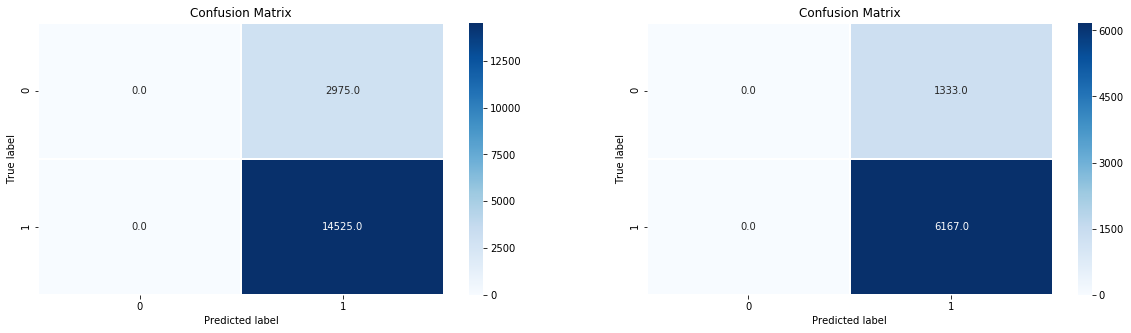

In [86]:
import seaborn as sns
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_train,pred_train)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test,pred_w2vtfidf)
df = pd.DataFrame(data=cm)
g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap="Blues")
g.set_title('Confusion Matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')

#### GBDT Using GridSearchCV

In [87]:
model_gbt.fit(X_trainw2vtfidf,y_train)
print(model_gbt.best_estimator_)

KeyboardInterrupt: 

## Conclusion
1)Decision tree does not perform well with text vectors,as you can see the accuracy in the performance table.
2)As you increase the range of max_depth, it will overfit and will become prone to outliers, so thats why we have taken range from 3 to 11.

## Performance Table

In [110]:
x = PrettyTable()

x.field_names = ["Featurization", "CV","Max_depth","Accuracy","F1 Score"]

x.add_row(["BOW","RandomSearch",11,85.43,0.82])
x.add_row(["TFIDF","GridSearch",11,85.5,0.82])
x.add_row(["AVG W2V","GridSearch",6,84.3,0.82])
x.add_row(["TFIDF W2V","RandomSearch",4,83.03,0.79])

print(x)


+---------------+--------------+-----------+----------+----------+
| Featurization |      CV      | Max_depth | Accuracy | F1 Score |
+---------------+--------------+-----------+----------+----------+
|      BOW      | RandomSearch |     11    |  85.43   |   0.82   |
|     TFIDF     |  GridSearch  |     11    |   85.5   |   0.82   |
|    AVG W2V    |  GridSearch  |     6     |   84.3   |   0.82   |
|   TFIDF W2V   | RandomSearch |     4     |  83.03   |   0.79   |
+---------------+--------------+-----------+----------+----------+
